## Hard Drive Failure Prediction in the Data Center


### Detect Failure via Classification

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import ast
import itertools
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from funcs_hrddrv import nboxplot, sctrmtrx, catbar

import dask
import dask.dataframe as dd

from sklearn import metrics
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest, BaggingClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.grid'] = True
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
# plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'
# plt.rcParams['xtick.top'] = True
# plt.rcParams['ytick.right'] = True
# plt.rcParams['xtick.bottom'] = True
# plt.rcParams['ytick.left'] = True

In [2]:
filelist = glob.glob(os.getcwd() + f'/data/p1_proc/*.csv')
filelist.sort()

with open('columns_select.txt', 'r') as f:
    cols = ast.literal_eval(f.read())
features = [c for c in cols if 'smart' in c]

dtypes = {}
dtypes['serial_number'] = 'string'
dtypes['model'] = 'string'
if 'capacity_bytes' in cols: dtypes['capacity_bytes'] = 'float' 
dtypes['failure'] = 'int'
dtypes['failure_date'] = 'object'
dtypes['time_to_failure'] = 'float'
dtypes['category'] = 'int'
dtypes.update({smart:'float' for smart in [c for c in cols if 'smart' in c]})

df = dd.concat([dd.read_csv(f, dtype=dtypes, parse_dates=['date', 'failure_date']) for f in filelist])
df.head()

,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_197_raw,smart_199_raw,smart_241_raw,smart_242_raw,failure_date,time_to_failure,category
0,2019-01-15,ZCH0CHT9,ST12000NM0007,0,219010250.0,4.0,0.0,242985377.0,377.083333,3.0,...,30.0,103.0,505.0,0.0,0.0,5.028254e+10,1.037452e+11,NaT,99999.0,3
1,2019-01-15,ZCH08P1R,ST12000NM0007,0,115422360.0,2.0,0.0,214319704.0,359.916667,1.0,...,28.0,119.0,610.0,0.0,0.0,4.720373e+10,7.400561e+10,NaT,99999.0,3
2,2019-01-15,ZCH06FX1,ST12000NM0007,0,158731520.0,2.0,0.0,538424549.0,444.208333,1.0,...,30.0,107.0,526.0,0.0,0.0,5.531850e+10,1.318521e+11,NaT,99999.0,3
3,2019-01-15,ZCH07E02,ST12000NM0007,0,204049360.0,3.0,0.0,94681323.0,432.000000,2.0,...,39.0,175.0,718.0,0.0,0.0,5.249663e+10,8.222903e+10,NaT,99999.0,3
4,2019-01-15,ZJV136WP,ST12000NM0007,0,226557040.0,3.0,0.0,257016250.0,90.833333,3.0,...,28.0,24.0,917.0,0.0,0.0,1.922293e+10,2.250764e+10,NaT,99999.0,3


### Resampling

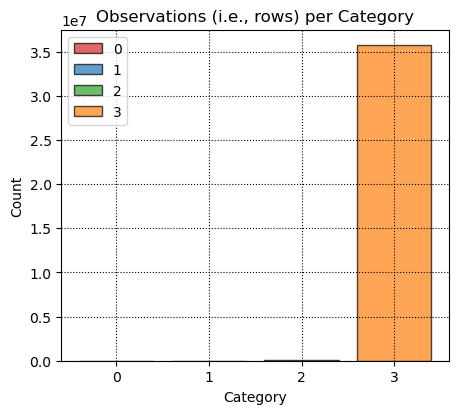

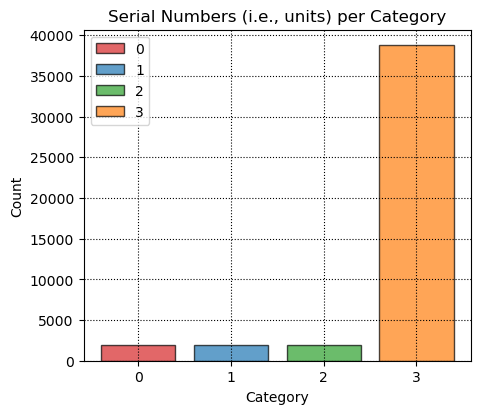

In [3]:
a = df[['category']].compute().value_counts().sort_index()
catbar(a, 'Observations (i.e., rows) per Category')

b = df[['category', 'serial_number']].groupby('category')['serial_number'].nunique().compute().sort_index()
catbar(b, 'Serial Numbers (i.e., units) per Category')

In [4]:
# resample serial numbers based on failed or not failed
sn_failed = df.loc[df['category'] < 3]['serial_number'].unique().compute()
sn_not_failed = df.loc[~df['serial_number'].isin(sn_failed)]['serial_number'].unique().compute()
sn_not_failed = sn_not_failed.sample(n=len(sn_failed), random_state=0)
sn_resample = list(set(sn_failed)) + list(set(sn_not_failed))

df = df.loc[df['serial_number'].isin(sn_resample)].compute()

# random down sample based on category
X = df.drop(columns='category').values
y = df['category'].values
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(X, y)

df = pd.DataFrame(X, columns=df.drop(columns='category').columns)
df['category'] = y

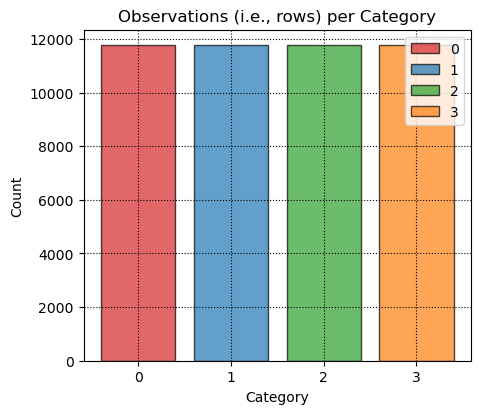

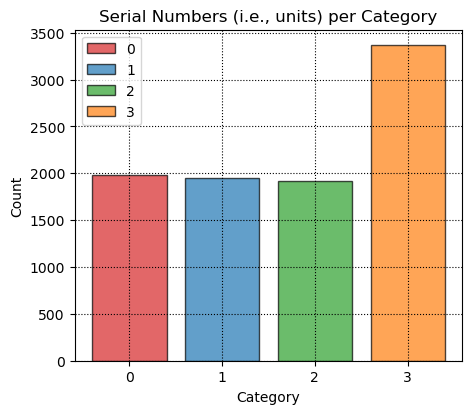

In [5]:
a = df[['category']].value_counts().sort_index()
catbar(a, 'Observations (i.e., rows) per Category')

b = df[['category', 'serial_number']].groupby('category')['serial_number'].nunique().sort_index()
catbar(b, 'Serial Numbers (i.e., units) per Category')

### Modeling

In [6]:
fit_models = {}

X = df[features].values
y = df['category'].values

# scale
ss = StandardScaler()
Xscaled = ss.fit_transform(X)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xscaled, y, test_size=0.25, shuffle=True, random_state=0)

df_scaled = pd.DataFrame(Xscaled, columns=features)
df_scaled['category'] = y

In [7]:
def box_compare(df, features):
    
    df = df.melt(id_vars=['category'], var_name='Feature', value_name='Distribution')

    plt.figure(figsize=(17, 4))

    ax = sns.boxplot(
                data=df,
                x="Feature", 
                y="Distribution",
                hue="category", 
                palette=['tab:red', 'tab:blue', 'tab:green', 'tab:orange'],
                notch=False, 
                showfliers=False,
                flierprops={"marker": "o"},
               )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.87, 1), ncol=4, title=None)
    ax.set_ylim(-3, 3)
    plt.xticks(rotation=60)
    plt.title('Feature Distributions for Categories 1-4 ')
    plt.show()

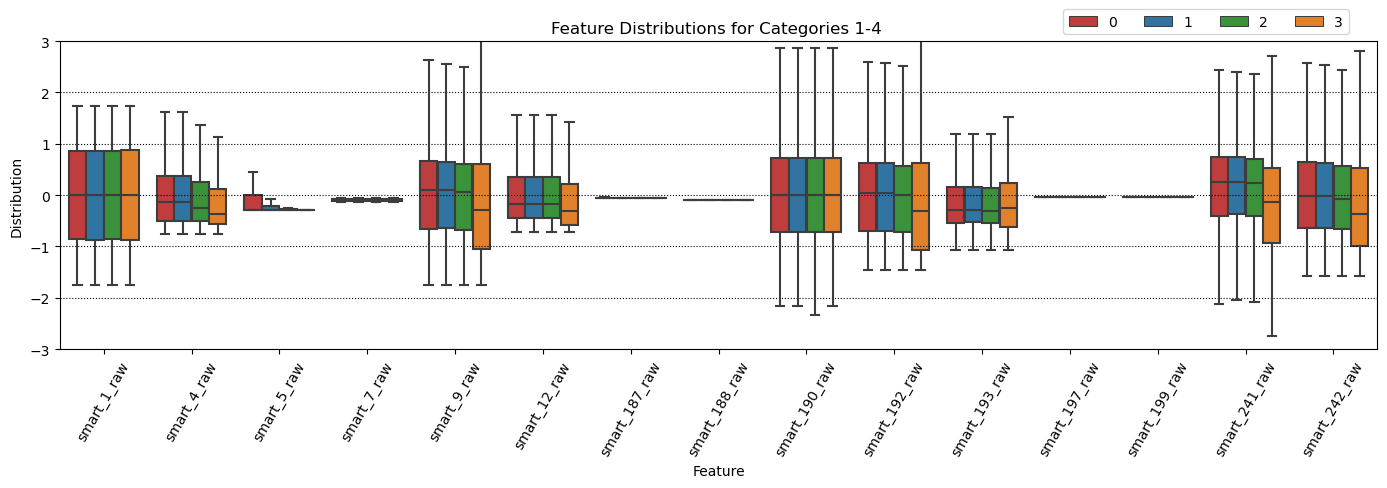

In [8]:
box_compare(df=df_scaled, features=features)

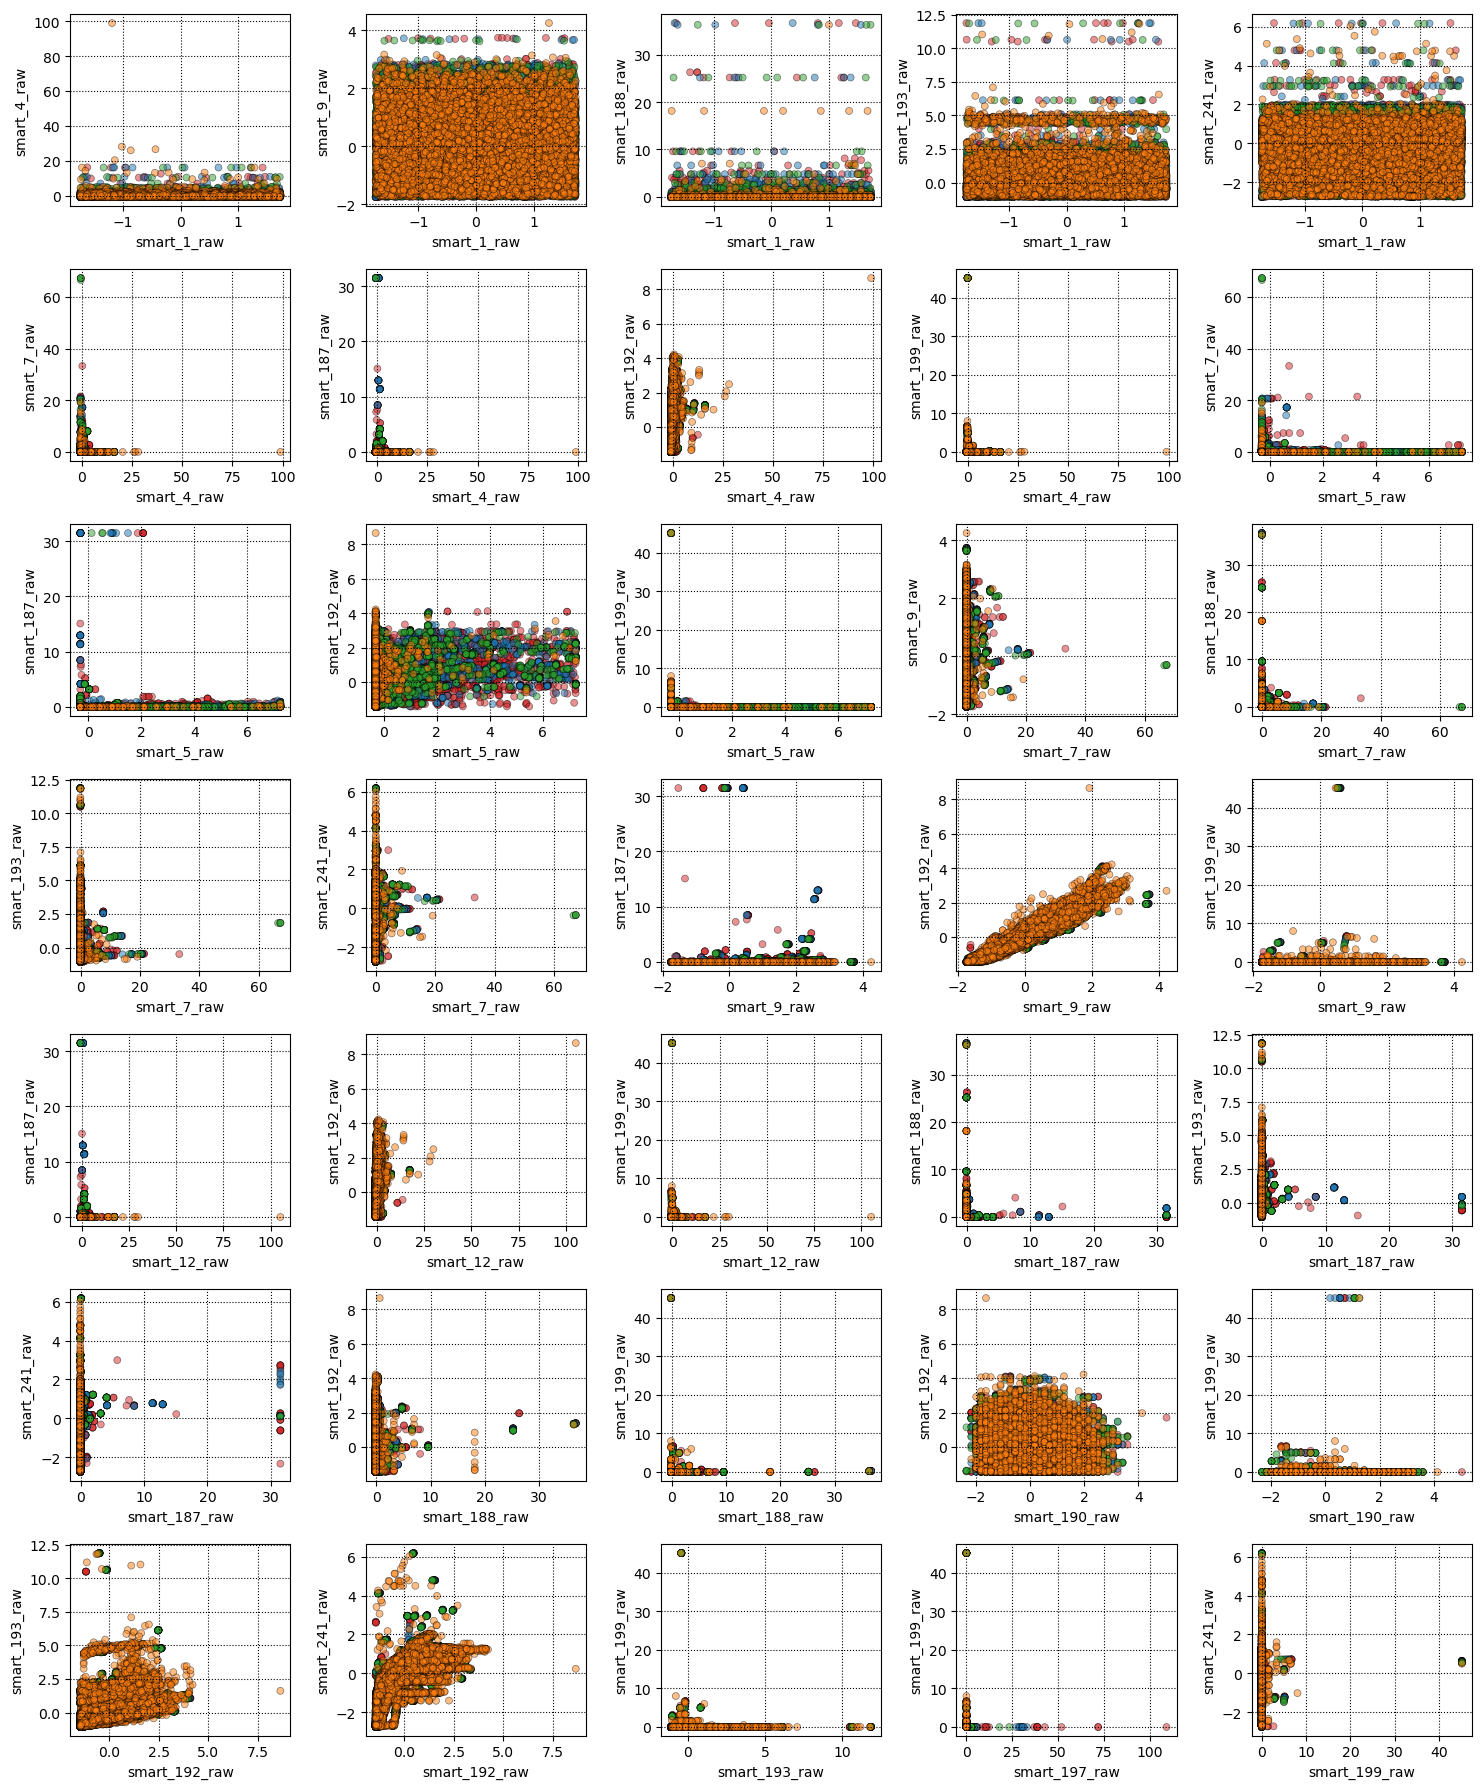

In [9]:
pairs = features
pairs = list(itertools.combinations(pairs, 2))
sctrmtrx(df=df_scaled, pairs=pairs[::3], m=7, n=5)

In [10]:
def gridsearch_fit(model, parameter_grid, X, y):
    """
    Grid Search and return fit model.
    
    Parameters:
        model: Model to search over and fit.
        parameter_grid: Model parameters to search over.
        X: Independent variables (features).
        y: Dependent variable (target).
    Returns: 
        Fit model.
    """
    grd = GridSearchCV(
                    model, 
                    param_grid=parameter_grid, 
                    cv=5, 
                    return_train_score=True, 
                    n_jobs=-1,
                    )
    grd = grd.fit(X, y)
    
    return grd

In [11]:
def train_rf(parameters, Xtrain, ytrain):
# Random Forest
    rf = RandomForestClassifier(
                    random_state=0, 
                    bootstrap=True,
                        )
    rf = gridsearch_fit(model=rf, 
                       parameter_grid=parameters, 
                       X=Xtrain, 
                       y=ytrain,
                       )
    print('RF Best parameters:', rf.best_params_)
    print('RF CV Best score:', rf.best_score_)
    return rf

def train_svm(parameters, Xtrain, ytrain):
    # SVM
    svm = SVC(kernel='rbf', probability=False)
    svm = gridsearch_fit(model=svm, 
                       parameter_grid=parameters, 
                       X=Xtrain, 
                       y=ytrain,
                      )
    print('SVM Best parameters:', svm.best_params_)
    print('SVM CV Best score:', svm.best_score_)
    svm = SVC(kernel='rbf', probability=True, **svm.best_params_)
    return svm.fit(X=Xtrain, y=ytrain)

def train_gbm(parameters, Xtrain, ytrain):
    # GBM
    gbm = GradientBoostingClassifier(random_state=0,)
    gbm = gridsearch_fit(model=gbm, 
                       parameter_grid=parameters, 
                       X=Xtrain, 
                       y=ytrain,
                      )
    print('GBM Best parameters:', gbm.best_params_)
    print('GBM CV Best score:', gbm.best_score_)
    return gbm

In [12]:
parameters_rf = {
                # 'n_estimators':np.arange(0, 1000, 200)[1:], 
                # 'max_depth':[None, 10, 5],
                # 'min_samples_split':[2, 4, 6, ],
                # 'min_samples_leaf':[1, 3, 5, ],
                # 'max_features':[15, 11, 9, 'sqrt'],
                # 'max_samples':[None, ytrain.shape[0]//2, ytrain.shape[0]//3, ],
                 }
parameters_rf = {'max_depth': [None], 'max_features': ['sqrt'], 'max_samples': [None], 'min_samples_leaf': [1], 'min_samples_split': [2], 'n_estimators': [600]}

parameters_svm = {
            # 'C':np.arange(0, 5500, 500)[1:],
            # 'gamma':np.logspace(-3, 0, 10), 
                 }
parameters_svm = {'C': [4000], 'gamma': [0.0215]}
parameters_gbm = {
                    # 'learning_rate':np.logspace(-2, 0, 7), 
                    # 'n_estimators':np.arange(800, 2200, 200)[1:],
                    # 'min_samples_split':[2, 4, 6, ],
                    # 'min_samples_leaf':[1, 3, 5, ],
                    # 'max_depth':[5, 10, 15, 20, 30],
                    # 'max_features':[15, 11, 9, 'sqrt', ],
                 }
parameters_gbm = {'learning_rate': [0.04], 'max_depth': [20], 'n_estimators': [1400]}

fit_models['RF'] = train_rf(parameters_rf, Xtrain, ytrain)
fit_models['SVM'] = train_svm(parameters_svm, Xtrain, ytrain)
fit_models['GBM'] = train_gbm(parameters_gbm, Xtrain, ytrain)

RF Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
RF CV Best score: 0.8269977187662214
SVM Best parameters: {'C': 4000, 'gamma': 0.0215}
SVM CV Best score: 0.4021033192393423
GBM Best parameters: {'learning_rate': 0.04, 'max_depth': 20, 'n_estimators': 1400}
GBM CV Best score: 0.8406044988276434


In [13]:
def feature_imp_plot(name, ensemble_model, features):
    """
    Feature importance plot for Random Forest or GBM.
    
    Parameters:
        name: Model name.
        ensemble_model: Model with feature_importances_ attribute.
        features: List of features corresponding to feature importances.
    """
    
    # feature importance
    ft_imp = pd.DataFrame(ensemble_model.feature_importances_)
    ft_imp.columns = ['Importance']
    ft_imp['Feature'] = features
    ft_imp = ft_imp.sort_values('Importance')

    cm = plt.cm.get_cmap('Reds')
    colors = [cm(val/len(features)) for val in range(len(features))]
    fig, ax = plt.subplots(figsize=(3, len(features) // 2))
    ax.barh(ft_imp['Feature'], ft_imp['Importance'], edgecolor='k', color=colors)
    ax.set_xlabel('Importance')
    ax.set_title(f'Feature Importance: {name}', size=12)
    plt.show()

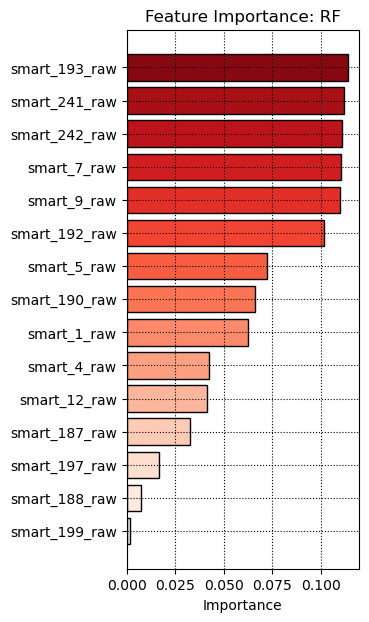

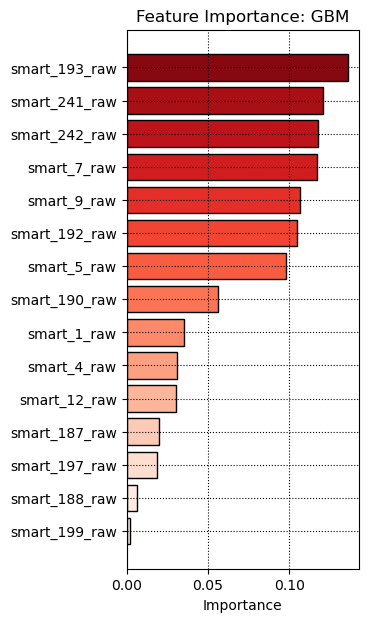

In [14]:
feature_imp_plot('RF', fit_models['RF'].best_estimator_, features)
feature_imp_plot('GBM', fit_models['GBM'].best_estimator_, features)

In [15]:
def prfm_rpt(fit_models, Xtest, Xtrain, ytest):
    """
    Generate performance results.
    
    Parameters:
        fit_models: Models to generate performance results for.
        Xtest: Test data set.
        Xtrain: Train data set.
        ytest: Test target data set.

    Returns: 
        ypreds, train_pred_probs, test_pred_probs
    """
    
    # classification reports
    target_names = [
                    'Category 0', 
                    'Category 1', 
                    'Category 2', 
                    'Category 3',
                   ]
    accuracy = {}
    ypreds = {}
    test_pred_probs = {}
    train_pred_probs = {}
    
    for m in fit_models:
        train_pred_probs[m] = fit_models[m].predict_proba(Xtrain)
        test_pred_probs[m] = fit_models[m].predict_proba(Xtest)
        ypreds[m] = fit_models[m].predict(Xtest)

    for m in fit_models:
        acc = metrics.accuracy_score(ytest, ypreds[m])
        accuracy[m] = acc
        print(f'Classification Report for {m}')
        print(metrics.classification_report(ytest, ypreds[m], target_names=target_names))
        print('Accuracy:', round(acc, 3), '\n')

        conf_mat = metrics.confusion_matrix(y_true=ytest, y_pred=ypreds[m], labels=fit_models[m].classes_,)
        print(conf_mat)
        print('-----------------------------------------------------------', '\n')
        
    return ypreds, train_pred_probs, test_pred_probs

In [16]:
df_scaled.groupby('category').count()

,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_190_raw,smart_192_raw,smart_193_raw,smart_197_raw,smart_199_raw,smart_241_raw,smart_242_raw
category,,,,,,,,,,,,,,,
0,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759
1,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759
2,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759
3,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759,11759


In [17]:
np.unique(ytest, return_counts=True) 

(array([0, 1, 2, 3]), array([2997, 2915, 2867, 2980]))

In [18]:
ypreds, train_pred_probs, test_pred_probs = prfm_rpt(
                    fit_models=fit_models,
                    Xtest=Xtest,
                    Xtrain=Xtrain,
                    ytest=ytest,
                    )

Classification Report for RF
              precision    recall  f1-score   support

  Category 0       0.87      0.90      0.89      2997
  Category 1       0.81      0.81      0.81      2915
  Category 2       0.85      0.86      0.86      2867
  Category 3       0.93      0.89      0.91      2980

    accuracy                           0.87     11759
   macro avg       0.87      0.87      0.87     11759
weighted avg       0.87      0.87      0.87     11759

Accuracy: 0.867 

[[2707  241   21   28]
 [ 298 2362  216   39]
 [  15  264 2462  126]
 [  81   51  187 2661]]
----------------------------------------------------------- 

Classification Report for SVM
              precision    recall  f1-score   support

  Category 0       0.50      0.35      0.41      2997
  Category 1       0.34      0.16      0.21      2915
  Category 2       0.32      0.39      0.35      2867
  Category 3       0.47      0.77      0.59      2980

    accuracy                           0.42     11759
   macr

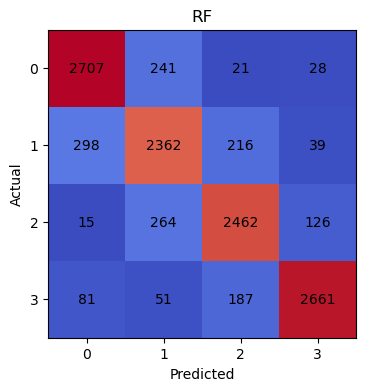

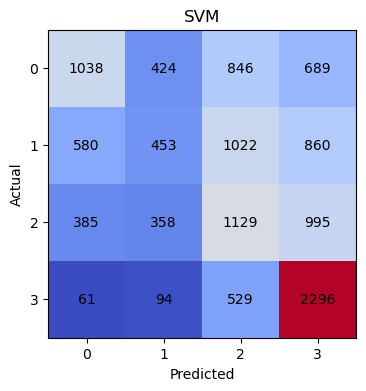

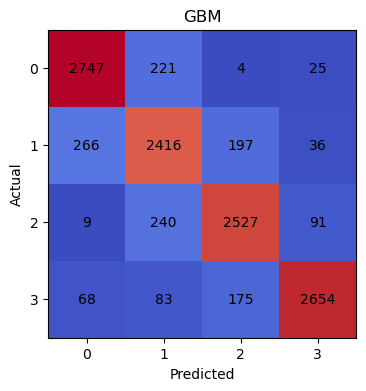

In [19]:
for m in fit_models:
    #print(m, '\n')
    conf_mat = metrics.confusion_matrix(y_true=ytest, y_pred=ypreds[m], labels=fit_models[m].classes_, normalize=None)

    fig, ax = plt.subplots(figsize=(5,4) )

    ax.matshow(conf_mat, cmap='coolwarm')
    for (i, j), z in np.ndenumerate(conf_mat):
        ax.text(j, i, f'{round(z, 3)}', ha='center', va='center',)

    ax.grid(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{m}', size=12)
    plt.show()

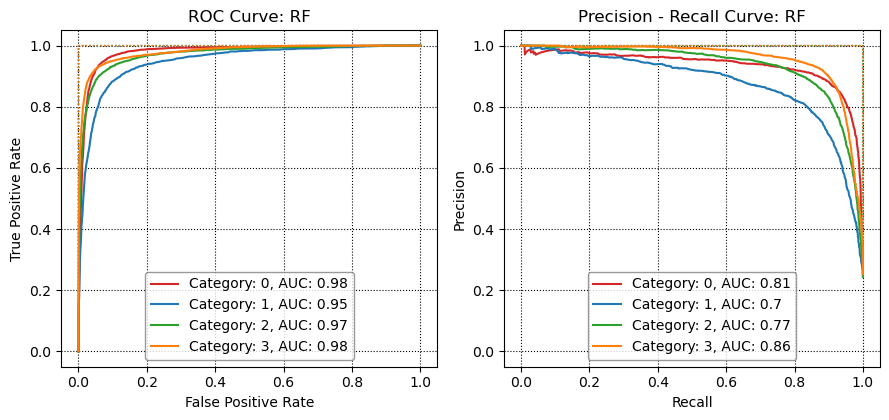

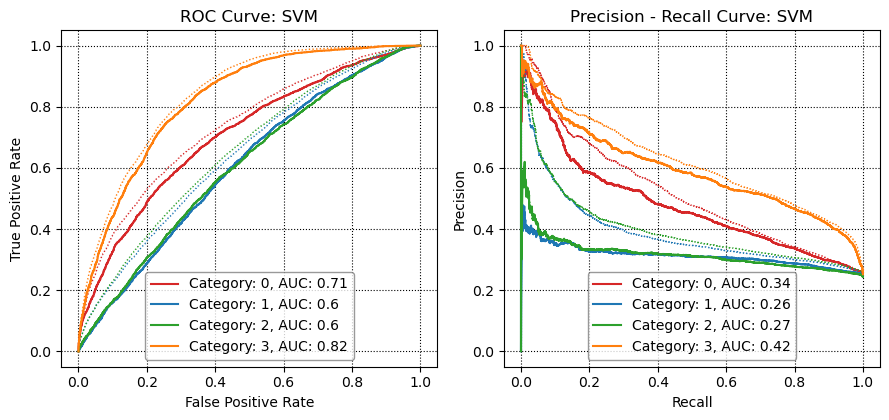

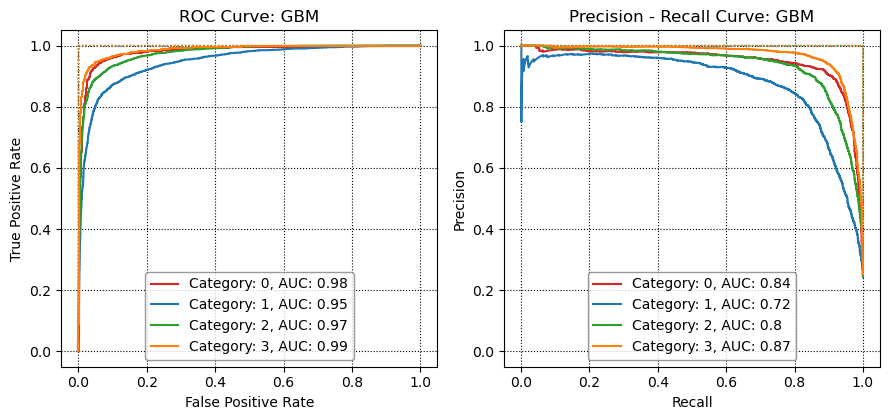

In [20]:
cmap = {0:'tab:red', 1:'tab:blue', 2:'tab:green', 3:'tab:orange'}
for m in fit_models:

    fig, ax = plt.subplots(1, 2, figsize=(9, 4.3))
    for category in [0, 1, 2, 3, ]:
        # Receiver operating characteristic (ROC)
        fpr_test, tpr_test, thresholds = metrics.roc_curve(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        rocauc = metrics.roc_auc_score(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        fpr_train, tpr_train, thresholds = metrics.roc_curve(np.where(ytrain == category, 1, 0), train_pred_probs[m][:, category])

        # plot ROC curve
        ax[0].plot(fpr_test, tpr_test, c=cmap[category], linewidth=1.5, label=f'Category: {category}, AUC: {round(rocauc, 2)}')
        ax[0].plot(fpr_train, tpr_train, linestyle=':', c=cmap[category], linewidth=1)
        ax[0].set_xlabel('False Positive Rate', )
        ax[0].set_ylabel('True Positive Rate', )
        ax[0].set_xlim(-0.05, 1.05)
        ax[0].set_ylim(-0.05, 1.05)
        ax[0].set_title('ROC Curve: '+ str(m), size=12)
        ax[0].legend(edgecolor='gray', facecolor='white', loc=8, fontsize=10)

        # precision recall
        precision_test, recall_test, thresholds = metrics.precision_recall_curve(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        PRauc = metrics.average_precision_score(np.where(ytest == category, 1, 0), np.where(ypreds[m] == category, 1, 0))
        precision_train, recall_train, thresholds = metrics.precision_recall_curve(np.where(ytrain == category, 1, 0), train_pred_probs[m][:, category])

        # plot precision recall curve
        ax[1].plot(recall_test, precision_test, c=cmap[category], linewidth=1.5, label=f'Category: {category}, AUC: {round(PRauc, 2)}')
        ax[1].plot(recall_train, precision_train, linestyle=':', c=cmap[category], linewidth=1)
        ax[1].set_xlabel('Recall', )
        ax[1].set_ylabel('Precision', )
        ax[1].set_xlim(-0.05, 1.05)
        ax[1].set_ylim(-0.05, 1.05)
        ax[1].set_title('Precision - Recall Curve: ' + str(m), size=12)
        ax[1].legend(edgecolor='gray', facecolor='white', loc=8, fontsize=10)
    plt.tight_layout()
#     plt.savefig(cwd + '/figures/ROC_PC_{}.png'.format(str(m).replace(' ', '_')))
    plt.show()

### Models with polynomial & interaction features

In [ ]:
# interaction features
pf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False, )
pf.fit(Xtrain)
Xtrain_poly = pf.transform(Xtrain)
Xtest_poly = pf.transform(Xtest)

In [ ]:
df_scaled

In [ ]:
pd.DataFrame(Xtrain_poly, columns=pf.get_feature_names_out())

In [ ]:
pf.get_feature_names_out()

In [ ]:
Xtrain_poly

In [ ]:
pf.get_feature_names()

In [ ]:
np.arange(1200, 2800, 200)[1:]

In [ ]:
Xtrain_poly.shape[1]//6

In [ ]:
parameters_rf = {
                # 'n_estimators':np.arange(0, 1000, 200)[1:], 
                # 'max_depth':[None, Xtrain_poly.shape[1]//4, Xtrain_poly.shape[1]//8],
                # 'min_samples_split':[2, 4, 6, ],
                # 'min_samples_leaf':[1, 3, 5, ],
                # 'max_features':[None, Xtrain_poly.shape[1]//2, 'sqrt'],
                # 'max_samples':[None, ytrain.shape[0]//2, ytrain.shape[0]//3, ],
                 }
parameters_rf = {'max_depth': [33], 'max_features': ['sqrt'], 'max_samples': [None], 'min_samples_leaf': [1], 'min_samples_split': [2], 'n_estimators': [600]}
parameters_svm = {
            # 'C':np.arange(0, 6500, 500)[1:],
            # 'gamma':np.logspace(-3, 0, 10), 
                 }
parameters_svm = {'C': [6000], 'gamma': [0.00215]}
parameters_gbm = {
                'learning_rate':np.logspace(-2, 0, 7), 
                'n_estimators':np.arange(800, 2200, 200)[1:],
                # 'min_samples_split':[2, 4, 6, ],
                # 'min_samples_leaf':[1, 3, 5, ],
                'max_depth':[Xtrain_poly.shape[1]//10, Xtrain_poly.shape[1]//15, Xtrain_poly.shape[1]//20],
                #'max_features':[None, Xtrain_poly.shape[1]//2, 'sqrt'],
                 }

# fit_models['RF_poly'] = train_rf(parameters_rf, Xtrain_poly, ytrain)
# fit_models['SVM_poly'] = train_svm(parameters_svm, Xtrain_poly, ytrain)
fit_models['GBM_poly'] = train_gbm(parameters_gbm, Xtrain_poly, ytrain)

In [ ]:
feature_imp_plot('RF_poly', fit_models['RF_poly'].best_estimator_, pf.get_feature_names())
feature_imp_plot('GBM_poly', fit_models['GBM_poly'].best_estimator_, pf.get_feature_names())

In [ ]:
ypreds_poly, train_pred_probs_poly, test_pred_probs_poly = prfm_rpt(
    fit_models={k:v for k, v in fit_models.items() if 'poly' in k},
    Xtest=Xtest_poly,
    Xtrain=Xtrain_poly,
    ytest=ytest,
    )

ypreds = ypreds | ypreds_poly
train_pred_probs = train_pred_probs | train_pred_probs_poly
test_pred_probs = test_pred_probs | test_pred_probs_poly

In [ ]:
l = list(fit_models.keys())
l.sort()
for m in l:
    #print(m, '\n')
    conf_mat = metrics.confusion_matrix(y_true=ytest, y_pred=ypreds[m], labels=fit_models[m].classes_, normalize=None)

    fig, ax = plt.subplots(figsize=(5,4) )

    ax.matshow(conf_mat, cmap='coolwarm')
    for (i, j), z in np.ndenumerate(conf_mat):
        ax.text(j, i, f'{round(z, 3)}', ha='center', va='center',)

    ax.grid(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{m}', size=12)
    plt.show()

In [ ]:
cmap = {0:'tab:red', 1:'tab:blue', 2:'tab:green', 3:'tab:orange'}
l = list(fit_models.keys())
l.sort()
for m in l:

    fig, ax = plt.subplots(1, 2, figsize=(9, 4.3))
    for category in [0, 1, 2, 3, ]:
        # Receiver operating characteristic (ROC)
        fpr_test, tpr_test, thresholds = metrics.roc_curve(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        rocauc = metrics.roc_auc_score(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        fpr_train, tpr_train, thresholds = metrics.roc_curve(np.where(ytrain == category, 1, 0), train_pred_probs[m][:, category])

        # plot ROC curve
        ax[0].plot(fpr_test, tpr_test, c=cmap[category], linewidth=1.5, label=f'Category: {category}, AUC: {round(rocauc, 2)}')
        ax[0].plot(fpr_train, tpr_train, linestyle=':', c=cmap[category], linewidth=1)
        ax[0].set_xlabel('False Positive Rate', )
        ax[0].set_ylabel('True Positive Rate', )
        ax[0].set_xlim(-0.05, 1.05)
        ax[0].set_ylim(-0.05, 1.05)
        ax[0].set_title('ROC Curve: '+ str(m), size=12)
        ax[0].legend(edgecolor='gray', facecolor='white', loc=8, fontsize=10)

        # precision recall
        precision_test, recall_test, thresholds = metrics.precision_recall_curve(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        PRauc = metrics.average_precision_score(np.where(ytest == category, 1, 0), np.where(ypreds[m] == category, 1, 0))
        precision_train, recall_train, thresholds = metrics.precision_recall_curve(np.where(ytrain == category, 1, 0), train_pred_probs[m][:, category])

        # plot precision recall curve
        ax[1].plot(recall_test, precision_test, c=cmap[category], linewidth=1.5, label=f'Category: {category}, AUC: {round(PRauc, 2)}')
        ax[1].plot(recall_train, precision_train, linestyle=':', c=cmap[category], linewidth=1)
        ax[1].set_xlabel('Recall', )
        ax[1].set_ylabel('Precision', )
        ax[1].set_xlim(-0.05, 1.05)
        ax[1].set_ylim(-0.05, 1.05)
        ax[1].set_title('Precision - Recall Curve: ' + str(m), size=12)
        ax[1].legend(edgecolor='gray', facecolor='white', loc=8, fontsize=10)
    plt.tight_layout()
#     plt.savefig(cwd + '/figures/ROC_PC_{}.png'.format(str(m).replace(' ', '_')))
    plt.show()